# Operador Neuronal de Fourier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# tomar n elementos de una secuencia
from itertools import islice as take

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

from utils import *

# barras de progreso
from tqdm import trange

torch.manual_seed(0)
np.random.seed(0)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Arquitectura

In [3]:
# Parte principal de la capa de Fourier
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, 
                                                             dtype=torch.cfloat))

    # Complex multiplication (batch matrix multiplication)
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        # ¡Es una suma de einstein! La primera entrada es el formato de la ecuación.
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        # Computes the one dimensional Fourier transform of real-valued input.
        x_ft = torch.fft.rfft(x)

        # Esta es la famosísima R
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, 
                             dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # La transformada inversa de Fourier.
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

In [4]:
class FourierLayerBlock(nn.Module):
    def __init__(self, modes, width):
        super(FourierLayerBlock, self).__init__()
        self.modes = modes
        self.width = width
        self.rama_superior = SpectralConv1d(self.width, self.width, self.modes)
        self.rama_inferior = nn.Conv1d(self.width, self.width, 1)
        
    def forward(self, x):
        x_sup = self.rama_superior(x)
        x_inf = self.rama_inferior(x)
        x = x_sup + x_inf
        x = F.relu(x)
        return x

In [5]:
class FNO1d(nn.Module):
    def __init__(self, modes, width, layers = 4):
        super(FNO1d, self).__init__()
        self.modes = modes
        self.width = width
        self.layers = layers
        self.fc0 = nn.Linear(2, self.width)

        self.module = nn.ModuleList()
        for idx in range(self.layers):
            fl = FourierLayerBlock(self.modes, self.width)
            self.module.append(fl)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # P
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # Las capas de Fourier
        for mod in self.module:
            x = mod(x)
        # Q
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## Configuraciones

In [6]:
ntrain = 1000
ntest = 200

sub = 2**3 #subsampling rate
# Esta h es el largo de los datos, el largo de la barra.
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 32
learning_rate = 0.001

epochs = 200
step_size = 100
gamma = 0.5

modes = 16 # Por qué? Por qué no menos?
width = 64

## Instanciando un modelo

In [7]:
model = FNO1d(modes, width)
print(model)

FNO1d(
  (fc0): Linear(in_features=2, out_features=64, bias=True)
  (module): ModuleList(
    (0): FourierLayerBlock(
      (rama_superior): SpectralConv1d()
      (rama_inferior): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
    (1): FourierLayerBlock(
      (rama_superior): SpectralConv1d()
      (rama_inferior): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
    (2): FourierLayerBlock(
      (rama_superior): SpectralConv1d()
      (rama_inferior): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
    (3): FourierLayerBlock(
      (rama_superior): SpectralConv1d()
      (rama_inferior): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


## Lectura de datos

In [8]:
%%time
# Data is of the shape (number of samples, grid size)
dataloader = MatReader('datasets/Burgers/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

# Conjunto de entrenamiento
x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
# Conjunto de pruebas
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

ntrain = int(ntrain*0.8)
neval = int(ntrain*0.2)

# Conjunto de entrenamiento
x_train = x_train[:ntrain,:]
y_train = y_train[:ntrain,:]
# Conjunto de evaluación
x_eval = x_train[-neval:,:]
y_eval = y_train[-neval:,:]

# cat the locations information
# Es como una cuadrícula dividida en s partes cambiada a 3 dimensiones
grid = np.linspace(0, 1, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_eval = torch.cat([x_eval.reshape(neval,s,1), grid.repeat(neval,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), 
                                           batch_size=batch_size, shuffle=True)
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_eval, y_eval), 
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), 
                                          batch_size=batch_size, shuffle=False)

CPU times: user 8.17 s, sys: 793 ms, total: 8.96 s
Wall time: 49.7 s


## Entrenamiento y evaluación

In [9]:
def train_epoch_GPU(dl, model, opt, scheduler):
    myloss = LpLoss(size_average=False)
    # Entrenamos por cada lote
    for x, y in dl:
        out = model(x.to(device))
        # Computamos la pérdida
        mse = F.mse_loss(out.view(batch_size, -1), y.to(device).view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.to(device).view(batch_size, -1))
        
        # Vaciamos los gradientes
        opt.zero_grad()
        
        # Retropropagamos
        l2.backward() # l2 pérdida relativa

        opt.step()
        
    scheduler.step()
    model.eval()
        
def eval_epoch_GPU(dl, model, num_batches=None):
    myloss = LpLoss(size_average=False)
    # Evitamos que se registren las operaciones en la gráfica de cómputo
    #pred = torch.zeros(y_test.shape)
    with torch.no_grad():
        # historiales
        losses, mses = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        test_l2 = 0
        for x, y_true in take(dl, num_batches):
            out = model(x.to(device))
            
            test_l2 = myloss(out.view(1, -1), y_true.to(device).view(1, -1)).item()
            test_mse = F.mse_loss(out.view(1, -1), y_true.to(device).view(1, -1), reduction='mean')
            losses.append(test_l2)
            mses.append(test_mse.cpu())
        # promediamos
        loss = np.mean(losses)
        mse = np.mean(mses)

        return loss, mse
        
        
def train_GPU(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
              trn_batches=None, tst_batches=None):
    myloss = LpLoss(size_average=False)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma)
    
    loss_hist = []
    mse_hist = []
    for epoch in trange(epochs):
        # entrenamos la época
        train_epoch_GPU(trn_dl, model, opt, scheduler)
        
        # evaluamos la época en entrenamiento
        trn_loss, trn_mse = eval_epoch_GPU(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_mse = eval_epoch_GPU(tst_dl, model, tst_batches)
        
        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        mse_hist.append([trn_mse, tst_mse])
        
        # imprimimos progreso
        print(f'E{epoch:02} \n'
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] \n'
              f'mse=[{trn_mse:6.2f},{tst_mse:6.2f}] \n')
    return loss_hist, mse_hist

## Entrenando modelo

In [10]:
%%time
# instanciamos un modelo
model = FNO1d(modes, width)
# entrenamos
#loss_hist, acc_hist = train(model, trn_dl, tst_dl)
epochs = 300
loss_hist, mse_hist = train_GPU(model.to(device), train_loader, eval_loader, epochs=epochs)

  0%|          | 1/300 [00:25<2:06:02, 25.29s/it]

E00 
loss=[  0.29,  0.29] 
mse=[  0.02,  0.02] 



  1%|          | 2/300 [00:25<52:51, 10.64s/it]  

E01 
loss=[  0.13,  0.13] 
mse=[  0.00,  0.00] 



  1%|          | 3/300 [00:26<29:29,  5.96s/it]

E02 
loss=[  0.09,  0.08] 
mse=[  0.00,  0.00] 



  1%|▏         | 4/300 [00:26<18:32,  3.76s/it]

E03 
loss=[  0.05,  0.05] 
mse=[  0.00,  0.00] 



  2%|▏         | 5/300 [00:26<12:29,  2.54s/it]

E04 
loss=[  0.14,  0.14] 
mse=[  0.00,  0.01] 



  2%|▏         | 6/300 [00:27<08:52,  1.81s/it]

E05 
loss=[  0.08,  0.08] 
mse=[  0.00,  0.00] 



  2%|▏         | 7/300 [00:27<06:34,  1.35s/it]

E06 
loss=[  0.13,  0.13] 
mse=[  0.00,  0.00] 



  3%|▎         | 8/300 [00:28<05:03,  1.04s/it]

E07 
loss=[  0.06,  0.06] 
mse=[  0.00,  0.00] 



  3%|▎         | 9/300 [00:28<04:03,  1.20it/s]

E08 
loss=[  0.04,  0.05] 
mse=[  0.00,  0.00] 



  3%|▎         | 10/300 [00:28<03:22,  1.43it/s]

E09 
loss=[  0.04,  0.05] 
mse=[  0.00,  0.00] 



  4%|▎         | 11/300 [00:29<02:54,  1.66it/s]

E10 
loss=[  0.04,  0.04] 
mse=[  0.00,  0.00] 



  4%|▍         | 12/300 [00:29<02:34,  1.86it/s]

E11 
loss=[  0.04,  0.04] 
mse=[  0.00,  0.00] 



  4%|▍         | 13/300 [00:29<02:20,  2.04it/s]

E12 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  5%|▍         | 14/300 [00:30<02:11,  2.17it/s]

E13 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  5%|▌         | 15/300 [00:30<02:05,  2.27it/s]

E14 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  5%|▌         | 16/300 [00:31<02:00,  2.35it/s]

E15 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  6%|▌         | 17/300 [00:31<01:57,  2.41it/s]

E16 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  6%|▌         | 18/300 [00:31<01:54,  2.45it/s]

E17 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  6%|▋         | 19/300 [00:32<01:52,  2.49it/s]

E18 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  7%|▋         | 20/300 [00:32<01:51,  2.50it/s]

E19 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



  7%|▋         | 21/300 [00:33<01:51,  2.51it/s]

E20 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  7%|▋         | 22/300 [00:33<01:49,  2.53it/s]

E21 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



  8%|▊         | 23/300 [00:33<01:49,  2.53it/s]

E22 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



  8%|▊         | 24/300 [00:34<01:48,  2.55it/s]

E23 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



  8%|▊         | 25/300 [00:34<01:47,  2.55it/s]

E24 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



  9%|▊         | 26/300 [00:35<01:47,  2.55it/s]

E25 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



  9%|▉         | 27/300 [00:35<01:46,  2.56it/s]

E26 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



  9%|▉         | 28/300 [00:35<01:46,  2.55it/s]

E27 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 10%|▉         | 29/300 [00:36<01:46,  2.56it/s]

E28 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 10%|█         | 30/300 [00:36<01:45,  2.57it/s]

E29 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 10%|█         | 31/300 [00:36<01:45,  2.56it/s]

E30 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 11%|█         | 32/300 [00:37<01:44,  2.57it/s]

E31 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 11%|█         | 33/300 [00:37<01:44,  2.56it/s]

E32 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 11%|█▏        | 34/300 [00:38<01:43,  2.56it/s]

E33 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 12%|█▏        | 35/300 [00:38<01:43,  2.55it/s]

E34 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 12%|█▏        | 36/300 [00:38<01:43,  2.56it/s]

E35 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 12%|█▏        | 37/300 [00:39<01:42,  2.56it/s]

E36 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 13%|█▎        | 38/300 [00:39<01:42,  2.56it/s]

E37 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 13%|█▎        | 39/300 [00:40<01:42,  2.54it/s]

E38 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 13%|█▎        | 40/300 [00:40<01:42,  2.55it/s]

E39 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 14%|█▎        | 41/300 [00:40<01:41,  2.54it/s]

E40 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 14%|█▍        | 42/300 [00:41<01:41,  2.54it/s]

E41 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 14%|█▍        | 43/300 [00:41<01:40,  2.56it/s]

E42 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 15%|█▍        | 44/300 [00:42<01:39,  2.56it/s]

E43 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 15%|█▌        | 45/300 [00:42<01:39,  2.56it/s]

E44 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 15%|█▌        | 46/300 [00:42<01:39,  2.56it/s]

E45 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 16%|█▌        | 47/300 [00:43<01:39,  2.55it/s]

E46 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 16%|█▌        | 48/300 [00:43<01:37,  2.57it/s]

E47 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 16%|█▋        | 49/300 [00:44<01:37,  2.57it/s]

E48 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 17%|█▋        | 50/300 [00:44<01:37,  2.57it/s]

E49 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 17%|█▋        | 51/300 [00:44<01:36,  2.57it/s]

E50 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 17%|█▋        | 52/300 [00:45<01:36,  2.57it/s]

E51 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 18%|█▊        | 53/300 [00:45<01:36,  2.57it/s]

E52 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 18%|█▊        | 54/300 [00:45<01:35,  2.56it/s]

E53 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 18%|█▊        | 55/300 [00:46<01:35,  2.57it/s]

E54 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 19%|█▊        | 56/300 [00:46<01:35,  2.56it/s]

E55 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 19%|█▉        | 57/300 [00:47<01:35,  2.54it/s]

E56 
loss=[  0.04,  0.03] 
mse=[  0.00,  0.00] 



 19%|█▉        | 58/300 [00:47<01:35,  2.54it/s]

E57 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 20%|█▉        | 59/300 [00:47<01:35,  2.54it/s]

E58 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 20%|██        | 60/300 [00:48<01:34,  2.54it/s]

E59 
loss=[  0.01,  0.02] 
mse=[  0.00,  0.00] 



 20%|██        | 61/300 [00:48<01:33,  2.54it/s]

E60 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 21%|██        | 62/300 [00:49<01:33,  2.54it/s]

E61 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 21%|██        | 63/300 [00:49<01:34,  2.52it/s]

E62 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 21%|██▏       | 64/300 [00:49<01:33,  2.52it/s]

E63 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 22%|██▏       | 65/300 [00:50<01:33,  2.52it/s]

E64 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 22%|██▏       | 66/300 [00:50<01:32,  2.53it/s]

E65 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 22%|██▏       | 67/300 [00:51<01:32,  2.51it/s]

E66 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 23%|██▎       | 68/300 [00:51<01:31,  2.53it/s]

E67 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 23%|██▎       | 69/300 [00:51<01:31,  2.53it/s]

E68 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 23%|██▎       | 70/300 [00:52<01:31,  2.52it/s]

E69 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 24%|██▎       | 71/300 [00:52<01:31,  2.50it/s]

E70 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 24%|██▍       | 72/300 [00:53<01:31,  2.49it/s]

E71 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 24%|██▍       | 73/300 [00:53<01:31,  2.48it/s]

E72 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 25%|██▍       | 74/300 [00:53<01:31,  2.47it/s]

E73 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 25%|██▌       | 75/300 [00:54<01:31,  2.47it/s]

E74 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 25%|██▌       | 76/300 [00:54<01:30,  2.47it/s]

E75 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 26%|██▌       | 77/300 [00:55<01:30,  2.47it/s]

E76 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 26%|██▌       | 78/300 [00:55<01:29,  2.47it/s]

E77 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 26%|██▋       | 79/300 [00:55<01:29,  2.46it/s]

E78 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 27%|██▋       | 80/300 [00:56<01:29,  2.46it/s]

E79 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 27%|██▋       | 81/300 [00:56<01:28,  2.46it/s]

E80 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 27%|██▋       | 82/300 [00:57<01:28,  2.46it/s]

E81 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 28%|██▊       | 83/300 [00:57<01:28,  2.46it/s]

E82 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 28%|██▊       | 84/300 [00:57<01:27,  2.46it/s]

E83 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 28%|██▊       | 85/300 [00:58<01:27,  2.46it/s]

E84 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 29%|██▊       | 86/300 [00:58<01:26,  2.46it/s]

E85 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 29%|██▉       | 87/300 [00:59<01:26,  2.45it/s]

E86 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 29%|██▉       | 88/300 [00:59<01:25,  2.47it/s]

E87 
loss=[  0.01,  0.02] 
mse=[  0.00,  0.00] 



 30%|██▉       | 89/300 [01:00<01:25,  2.46it/s]

E88 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 30%|███       | 90/300 [01:00<01:25,  2.46it/s]

E89 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 30%|███       | 91/300 [01:00<01:25,  2.45it/s]

E90 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 31%|███       | 92/300 [01:01<01:25,  2.43it/s]

E91 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 31%|███       | 93/300 [01:01<01:24,  2.45it/s]

E92 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 31%|███▏      | 94/300 [01:02<01:23,  2.46it/s]

E93 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 32%|███▏      | 95/300 [01:02<01:23,  2.46it/s]

E94 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 32%|███▏      | 96/300 [01:02<01:23,  2.45it/s]

E95 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 32%|███▏      | 97/300 [01:03<01:22,  2.45it/s]

E96 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 33%|███▎      | 98/300 [01:03<01:23,  2.42it/s]

E97 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 33%|███▎      | 99/300 [01:04<01:22,  2.43it/s]

E98 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 33%|███▎      | 100/300 [01:04<01:22,  2.43it/s]

E99 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 34%|███▎      | 101/300 [01:04<01:21,  2.44it/s]

E100 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 34%|███▍      | 102/300 [01:05<01:20,  2.46it/s]

E101 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 34%|███▍      | 103/300 [01:05<01:20,  2.45it/s]

E102 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 35%|███▍      | 104/300 [01:06<01:20,  2.44it/s]

E103 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 35%|███▌      | 105/300 [01:06<01:19,  2.45it/s]

E104 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 35%|███▌      | 106/300 [01:06<01:19,  2.45it/s]

E105 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 36%|███▌      | 107/300 [01:07<01:18,  2.46it/s]

E106 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 36%|███▌      | 108/300 [01:07<01:17,  2.47it/s]

E107 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 36%|███▋      | 109/300 [01:08<01:17,  2.47it/s]

E108 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 37%|███▋      | 110/300 [01:08<01:17,  2.47it/s]

E109 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 37%|███▋      | 111/300 [01:08<01:16,  2.47it/s]

E110 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 37%|███▋      | 112/300 [01:09<01:16,  2.47it/s]

E111 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 38%|███▊      | 113/300 [01:09<01:15,  2.47it/s]

E112 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 38%|███▊      | 114/300 [01:10<01:15,  2.48it/s]

E113 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 38%|███▊      | 115/300 [01:10<01:14,  2.48it/s]

E114 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 39%|███▊      | 116/300 [01:10<01:14,  2.47it/s]

E115 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 39%|███▉      | 117/300 [01:11<01:13,  2.47it/s]

E116 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 39%|███▉      | 118/300 [01:11<01:13,  2.46it/s]

E117 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 40%|███▉      | 119/300 [01:12<01:13,  2.45it/s]

E118 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 40%|████      | 120/300 [01:12<01:13,  2.45it/s]

E119 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 40%|████      | 121/300 [01:13<01:12,  2.46it/s]

E120 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 41%|████      | 122/300 [01:13<01:12,  2.47it/s]

E121 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 41%|████      | 123/300 [01:13<01:11,  2.47it/s]

E122 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 41%|████▏     | 124/300 [01:14<01:11,  2.47it/s]

E123 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 42%|████▏     | 125/300 [01:14<01:10,  2.47it/s]

E124 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 42%|████▏     | 126/300 [01:15<01:10,  2.48it/s]

E125 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 42%|████▏     | 127/300 [01:15<01:09,  2.48it/s]

E126 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 43%|████▎     | 128/300 [01:15<01:09,  2.47it/s]

E127 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 43%|████▎     | 129/300 [01:16<01:09,  2.47it/s]

E128 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 43%|████▎     | 130/300 [01:16<01:08,  2.48it/s]

E129 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 44%|████▎     | 131/300 [01:17<01:08,  2.48it/s]

E130 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 44%|████▍     | 132/300 [01:17<01:07,  2.48it/s]

E131 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 44%|████▍     | 133/300 [01:17<01:06,  2.50it/s]

E132 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 45%|████▍     | 134/300 [01:18<01:06,  2.51it/s]

E133 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 45%|████▌     | 135/300 [01:18<01:05,  2.50it/s]

E134 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 45%|████▌     | 136/300 [01:19<01:05,  2.49it/s]

E135 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 46%|████▌     | 137/300 [01:19<01:05,  2.48it/s]

E136 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 46%|████▌     | 138/300 [01:19<01:05,  2.48it/s]

E137 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 46%|████▋     | 139/300 [01:20<01:05,  2.47it/s]

E138 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 47%|████▋     | 140/300 [01:20<01:04,  2.47it/s]

E139 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 47%|████▋     | 141/300 [01:21<01:04,  2.47it/s]

E140 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 47%|████▋     | 142/300 [01:21<01:03,  2.47it/s]

E141 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 48%|████▊     | 143/300 [01:21<01:03,  2.47it/s]

E142 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 48%|████▊     | 144/300 [01:22<01:03,  2.46it/s]

E143 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 48%|████▊     | 145/300 [01:22<01:03,  2.46it/s]

E144 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 49%|████▊     | 146/300 [01:23<01:02,  2.46it/s]

E145 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 49%|████▉     | 147/300 [01:23<01:02,  2.45it/s]

E146 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 49%|████▉     | 148/300 [01:23<01:01,  2.46it/s]

E147 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 50%|████▉     | 149/300 [01:24<01:01,  2.46it/s]

E148 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 50%|█████     | 150/300 [01:24<01:00,  2.46it/s]

E149 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 50%|█████     | 151/300 [01:25<01:00,  2.46it/s]

E150 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 51%|█████     | 152/300 [01:25<01:00,  2.44it/s]

E151 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 51%|█████     | 153/300 [01:25<01:00,  2.42it/s]

E152 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 51%|█████▏    | 154/300 [01:26<01:00,  2.42it/s]

E153 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 52%|█████▏    | 155/300 [01:26<00:59,  2.43it/s]

E154 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 52%|█████▏    | 156/300 [01:27<00:59,  2.43it/s]

E155 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 52%|█████▏    | 157/300 [01:27<00:58,  2.44it/s]

E156 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 53%|█████▎    | 158/300 [01:28<00:57,  2.45it/s]

E157 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 53%|█████▎    | 159/300 [01:28<00:57,  2.44it/s]

E158 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 53%|█████▎    | 160/300 [01:28<00:57,  2.42it/s]

E159 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 54%|█████▎    | 161/300 [01:29<00:57,  2.43it/s]

E160 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 54%|█████▍    | 162/300 [01:29<00:56,  2.44it/s]

E161 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 54%|█████▍    | 163/300 [01:30<00:56,  2.45it/s]

E162 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 55%|█████▍    | 164/300 [01:30<00:55,  2.45it/s]

E163 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 55%|█████▌    | 165/300 [01:30<00:55,  2.45it/s]

E164 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 55%|█████▌    | 166/300 [01:31<00:55,  2.44it/s]

E165 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 56%|█████▌    | 167/300 [01:31<00:55,  2.41it/s]

E166 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 56%|█████▌    | 168/300 [01:32<00:54,  2.41it/s]

E167 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 56%|█████▋    | 169/300 [01:32<00:54,  2.41it/s]

E168 
loss=[  0.03,  0.03] 
mse=[  0.00,  0.00] 



 57%|█████▋    | 170/300 [01:32<00:53,  2.43it/s]

E169 
loss=[  0.02,  0.02] 
mse=[  0.00,  0.00] 



 57%|█████▋    | 171/300 [01:33<00:53,  2.43it/s]

E170 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 57%|█████▋    | 172/300 [01:33<00:52,  2.44it/s]

E171 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 58%|█████▊    | 173/300 [01:34<00:52,  2.44it/s]

E172 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 58%|█████▊    | 174/300 [01:34<00:51,  2.44it/s]

E173 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 58%|█████▊    | 175/300 [01:35<00:51,  2.44it/s]

E174 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 59%|█████▊    | 176/300 [01:35<00:50,  2.44it/s]

E175 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 59%|█████▉    | 177/300 [01:35<00:50,  2.43it/s]

E176 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 59%|█████▉    | 178/300 [01:36<00:50,  2.43it/s]

E177 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 60%|█████▉    | 179/300 [01:36<00:49,  2.42it/s]

E178 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 60%|██████    | 180/300 [01:37<00:49,  2.42it/s]

E179 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 60%|██████    | 181/300 [01:37<00:49,  2.42it/s]

E180 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 61%|██████    | 182/300 [01:37<00:48,  2.42it/s]

E181 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 61%|██████    | 183/300 [01:38<00:48,  2.43it/s]

E182 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 61%|██████▏   | 184/300 [01:38<00:48,  2.40it/s]

E183 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 62%|██████▏   | 185/300 [01:39<00:48,  2.38it/s]

E184 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 62%|██████▏   | 186/300 [01:39<00:48,  2.37it/s]

E185 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 62%|██████▏   | 187/300 [01:40<00:47,  2.37it/s]

E186 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 63%|██████▎   | 188/300 [01:40<00:47,  2.38it/s]

E187 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 63%|██████▎   | 189/300 [01:40<00:46,  2.39it/s]

E188 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 63%|██████▎   | 190/300 [01:41<00:45,  2.40it/s]

E189 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 64%|██████▎   | 191/300 [01:41<00:45,  2.39it/s]

E190 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 64%|██████▍   | 192/300 [01:42<00:45,  2.38it/s]

E191 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 64%|██████▍   | 193/300 [01:42<00:45,  2.36it/s]

E192 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 65%|██████▍   | 194/300 [01:42<00:44,  2.36it/s]

E193 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 65%|██████▌   | 195/300 [01:43<00:44,  2.35it/s]

E194 
loss=[  0.01,  0.02] 
mse=[  0.00,  0.00] 



 65%|██████▌   | 196/300 [01:43<00:44,  2.36it/s]

E195 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 66%|██████▌   | 197/300 [01:44<00:43,  2.35it/s]

E196 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 66%|██████▌   | 198/300 [01:44<00:43,  2.36it/s]

E197 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 66%|██████▋   | 199/300 [01:45<00:42,  2.37it/s]

E198 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 67%|██████▋   | 200/300 [01:45<00:41,  2.39it/s]

E199 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 67%|██████▋   | 201/300 [01:45<00:41,  2.39it/s]

E200 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 67%|██████▋   | 202/300 [01:46<00:41,  2.38it/s]

E201 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 68%|██████▊   | 203/300 [01:46<00:40,  2.37it/s]

E202 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 68%|██████▊   | 204/300 [01:47<00:40,  2.37it/s]

E203 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 68%|██████▊   | 205/300 [01:47<00:40,  2.36it/s]

E204 
loss=[  0.01,  0.00] 
mse=[  0.00,  0.00] 



 69%|██████▊   | 206/300 [01:48<00:39,  2.37it/s]

E205 
loss=[  0.01,  0.00] 
mse=[  0.00,  0.00] 



 69%|██████▉   | 207/300 [01:48<00:39,  2.38it/s]

E206 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 69%|██████▉   | 208/300 [01:48<00:38,  2.37it/s]

E207 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 70%|██████▉   | 209/300 [01:49<00:38,  2.36it/s]

E208 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 70%|███████   | 210/300 [01:49<00:38,  2.36it/s]

E209 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 70%|███████   | 211/300 [01:50<00:37,  2.37it/s]

E210 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 71%|███████   | 212/300 [01:50<00:37,  2.37it/s]

E211 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 71%|███████   | 213/300 [01:51<00:36,  2.35it/s]

E212 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 71%|███████▏  | 214/300 [01:51<00:36,  2.36it/s]

E213 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 72%|███████▏  | 215/300 [01:51<00:35,  2.37it/s]

E214 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 72%|███████▏  | 216/300 [01:52<00:35,  2.38it/s]

E215 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 72%|███████▏  | 217/300 [01:52<00:34,  2.38it/s]

E216 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 73%|███████▎  | 218/300 [01:53<00:34,  2.36it/s]

E217 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 73%|███████▎  | 219/300 [01:53<00:34,  2.37it/s]

E218 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 73%|███████▎  | 220/300 [01:53<00:33,  2.37it/s]

E219 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 74%|███████▎  | 221/300 [01:54<00:33,  2.36it/s]

E220 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 74%|███████▍  | 222/300 [01:54<00:33,  2.36it/s]

E221 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 74%|███████▍  | 223/300 [01:55<00:32,  2.37it/s]

E222 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 75%|███████▍  | 224/300 [01:55<00:32,  2.36it/s]

E223 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 75%|███████▌  | 225/300 [01:56<00:31,  2.35it/s]

E224 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 75%|███████▌  | 226/300 [01:56<00:31,  2.37it/s]

E225 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 76%|███████▌  | 227/300 [01:56<00:30,  2.37it/s]

E226 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 76%|███████▌  | 228/300 [01:57<00:30,  2.37it/s]

E227 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 76%|███████▋  | 229/300 [01:57<00:29,  2.37it/s]

E228 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 77%|███████▋  | 230/300 [01:58<00:29,  2.36it/s]

E229 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 77%|███████▋  | 231/300 [01:58<00:29,  2.37it/s]

E230 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 77%|███████▋  | 232/300 [01:59<00:28,  2.37it/s]

E231 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 78%|███████▊  | 233/300 [01:59<00:28,  2.37it/s]

E232 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 78%|███████▊  | 234/300 [01:59<00:27,  2.38it/s]

E233 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 78%|███████▊  | 235/300 [02:00<00:27,  2.37it/s]

E234 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 79%|███████▊  | 236/300 [02:00<00:26,  2.37it/s]

E235 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 79%|███████▉  | 237/300 [02:01<00:26,  2.37it/s]

E236 
loss=[  0.00,  0.01] 
mse=[  0.00,  0.00] 



 79%|███████▉  | 238/300 [02:01<00:26,  2.36it/s]

E237 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 80%|███████▉  | 239/300 [02:01<00:25,  2.36it/s]

E238 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 80%|████████  | 240/300 [02:02<00:25,  2.36it/s]

E239 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 80%|████████  | 241/300 [02:02<00:24,  2.37it/s]

E240 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 81%|████████  | 242/300 [02:03<00:24,  2.37it/s]

E241 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 81%|████████  | 243/300 [02:03<00:23,  2.39it/s]

E242 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 81%|████████▏ | 244/300 [02:04<00:23,  2.39it/s]

E243 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 82%|████████▏ | 245/300 [02:04<00:23,  2.39it/s]

E244 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 82%|████████▏ | 246/300 [02:04<00:22,  2.38it/s]

E245 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 82%|████████▏ | 247/300 [02:05<00:22,  2.38it/s]

E246 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 83%|████████▎ | 248/300 [02:05<00:21,  2.38it/s]

E247 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 83%|████████▎ | 249/300 [02:06<00:21,  2.39it/s]

E248 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 83%|████████▎ | 250/300 [02:06<00:20,  2.38it/s]

E249 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 84%|████████▎ | 251/300 [02:07<00:20,  2.37it/s]

E250 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 84%|████████▍ | 252/300 [02:07<00:20,  2.38it/s]

E251 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 84%|████████▍ | 253/300 [02:07<00:19,  2.36it/s]

E252 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 85%|████████▍ | 254/300 [02:08<00:19,  2.36it/s]

E253 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 85%|████████▌ | 255/300 [02:08<00:19,  2.36it/s]

E254 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 85%|████████▌ | 256/300 [02:09<00:18,  2.36it/s]

E255 
loss=[  0.00,  0.01] 
mse=[  0.00,  0.00] 



 86%|████████▌ | 257/300 [02:09<00:18,  2.36it/s]

E256 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 86%|████████▌ | 258/300 [02:10<00:17,  2.34it/s]

E257 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 86%|████████▋ | 259/300 [02:10<00:17,  2.33it/s]

E258 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 87%|████████▋ | 260/300 [02:10<00:17,  2.34it/s]

E259 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 87%|████████▋ | 261/300 [02:11<00:16,  2.35it/s]

E260 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 87%|████████▋ | 262/300 [02:11<00:16,  2.35it/s]

E261 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 88%|████████▊ | 263/300 [02:12<00:15,  2.33it/s]

E262 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 88%|████████▊ | 264/300 [02:12<00:15,  2.33it/s]

E263 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 88%|████████▊ | 265/300 [02:13<00:14,  2.34it/s]

E264 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 89%|████████▊ | 266/300 [02:13<00:14,  2.34it/s]

E265 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 89%|████████▉ | 267/300 [02:13<00:14,  2.35it/s]

E266 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 89%|████████▉ | 268/300 [02:14<00:13,  2.34it/s]

E267 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 90%|████████▉ | 269/300 [02:14<00:13,  2.35it/s]

E268 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 90%|█████████ | 270/300 [02:15<00:12,  2.35it/s]

E269 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 90%|█████████ | 271/300 [02:15<00:12,  2.34it/s]

E270 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 91%|█████████ | 272/300 [02:15<00:11,  2.36it/s]

E271 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 91%|█████████ | 273/300 [02:16<00:11,  2.36it/s]

E272 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 91%|█████████▏| 274/300 [02:16<00:10,  2.37it/s]

E273 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 92%|█████████▏| 275/300 [02:17<00:10,  2.37it/s]

E274 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 92%|█████████▏| 276/300 [02:17<00:10,  2.38it/s]

E275 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 92%|█████████▏| 277/300 [02:18<00:09,  2.38it/s]

E276 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 93%|█████████▎| 278/300 [02:18<00:09,  2.36it/s]

E277 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 93%|█████████▎| 279/300 [02:18<00:08,  2.37it/s]

E278 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 93%|█████████▎| 280/300 [02:19<00:08,  2.37it/s]

E279 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 94%|█████████▎| 281/300 [02:19<00:08,  2.37it/s]

E280 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 94%|█████████▍| 282/300 [02:20<00:07,  2.37it/s]

E281 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 94%|█████████▍| 283/300 [02:20<00:07,  2.37it/s]

E282 
loss=[  0.01,  0.00] 
mse=[  0.00,  0.00] 



 95%|█████████▍| 284/300 [02:21<00:06,  2.36it/s]

E283 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 95%|█████████▌| 285/300 [02:21<00:06,  2.36it/s]

E284 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 95%|█████████▌| 286/300 [02:21<00:05,  2.36it/s]

E285 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 96%|█████████▌| 287/300 [02:22<00:05,  2.36it/s]

E286 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 96%|█████████▌| 288/300 [02:22<00:05,  2.37it/s]

E287 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 96%|█████████▋| 289/300 [02:23<00:04,  2.35it/s]

E288 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 



 97%|█████████▋| 290/300 [02:23<00:04,  2.35it/s]

E289 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 97%|█████████▋| 291/300 [02:24<00:03,  2.35it/s]

E290 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 97%|█████████▋| 292/300 [02:24<00:03,  2.36it/s]

E291 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 98%|█████████▊| 293/300 [02:24<00:02,  2.34it/s]

E292 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 98%|█████████▊| 294/300 [02:25<00:02,  2.35it/s]

E293 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 98%|█████████▊| 295/300 [02:25<00:02,  2.35it/s]

E294 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 99%|█████████▊| 296/300 [02:26<00:01,  2.34it/s]

E295 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 99%|█████████▉| 297/300 [02:26<00:01,  2.33it/s]

E296 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



 99%|█████████▉| 298/300 [02:27<00:00,  2.33it/s]

E297 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



100%|█████████▉| 299/300 [02:27<00:00,  2.34it/s]

E298 
loss=[  0.00,  0.00] 
mse=[  0.00,  0.00] 



100%|██████████| 300/300 [02:27<00:00,  2.03it/s]

E299 
loss=[  0.01,  0.01] 
mse=[  0.00,  0.00] 

CPU times: user 2min 7s, sys: 2.37 s, total: 2min 10s
Wall time: 4min 24s


/home/oscar/Escritorio/ProyectoDL/utils.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(yt, color = c, fontsize = 15)
/home/oscar/Escritorio/ProyectoDL/utils.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([int(x) for x in xt], color = c, fontsize = 15)


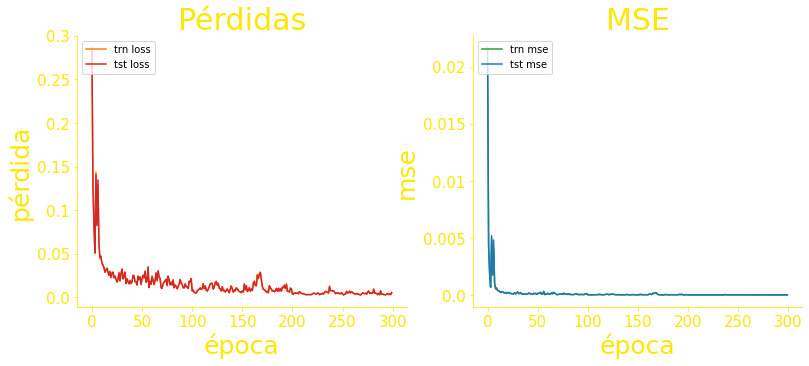

In [11]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, name = f"metric_{epochs}epochs_burger")

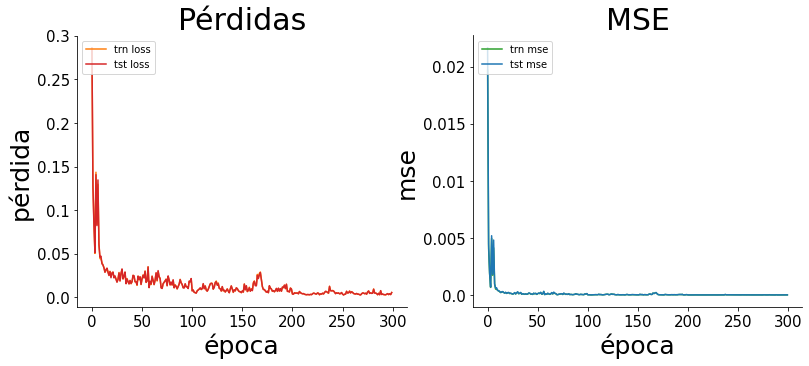

In [12]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, name = f"metric_{epochs}epochs_burger_black", c="black")

## Evaluamos en entrenamiento

In [13]:
with torch.no_grad(): 
    preds = []
    y_trues = []
    for x, y_true in test_loader:
        out = model(x.to(device))
        y_trues.append(y_true)
        preds.append(out.squeeze().cpu())

<ipython-input-28-f50f32ec1ea9>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (10,2))


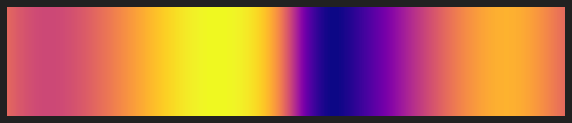

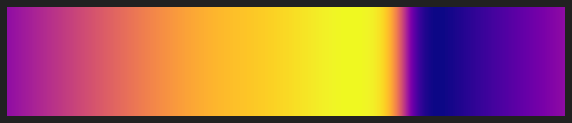

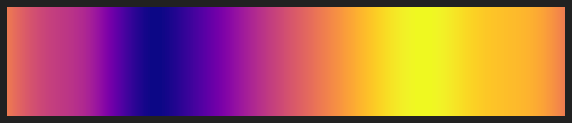

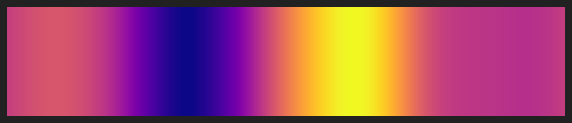

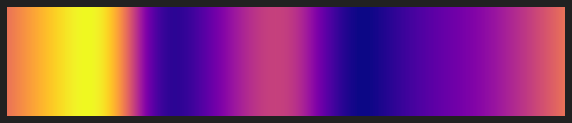

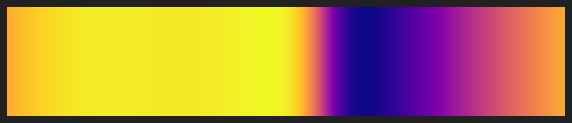

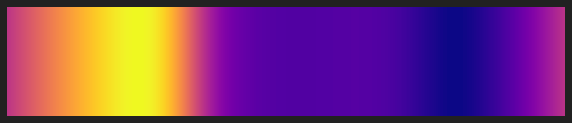

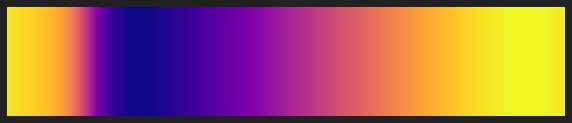

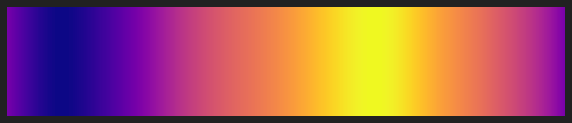

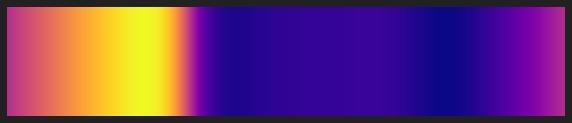

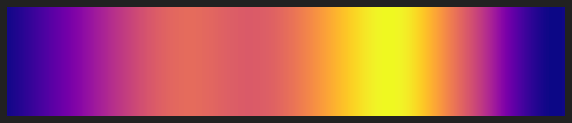

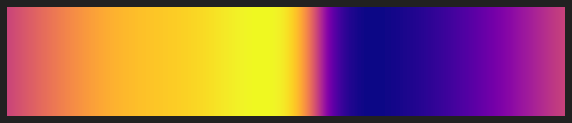

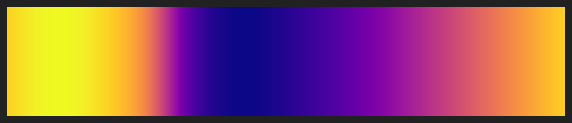

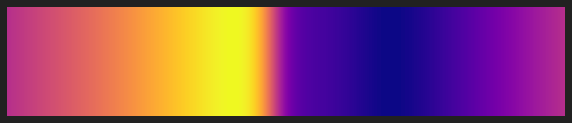

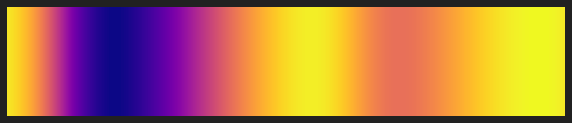

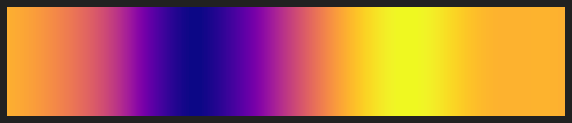

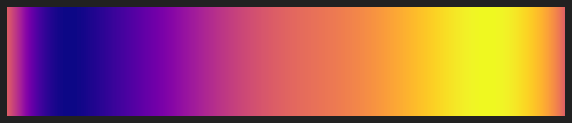

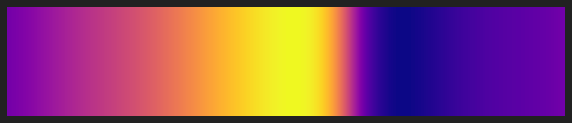

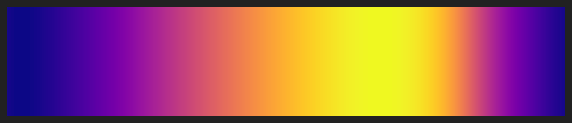

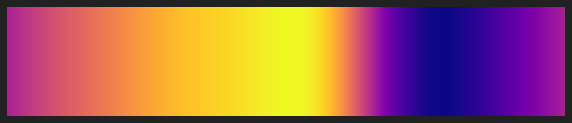

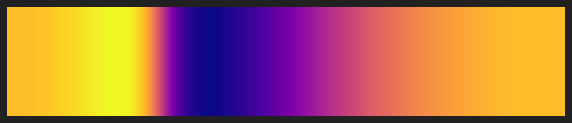

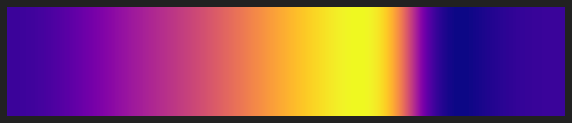

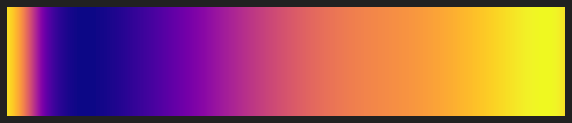

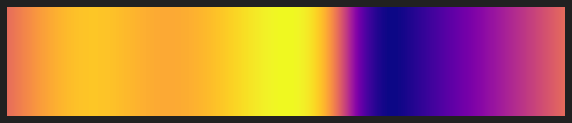

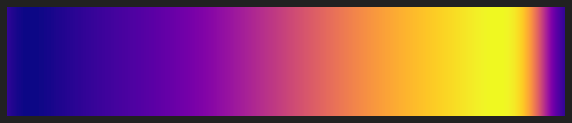

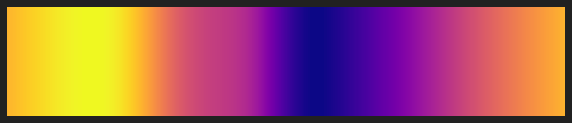

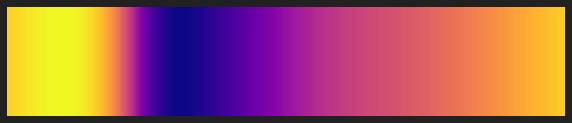

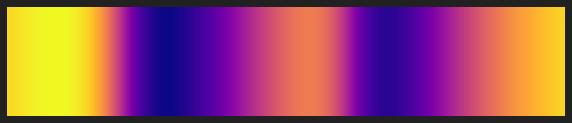

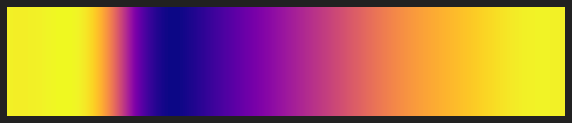

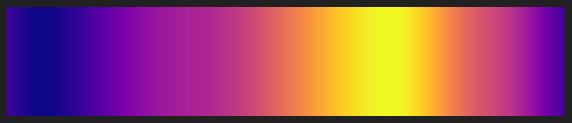

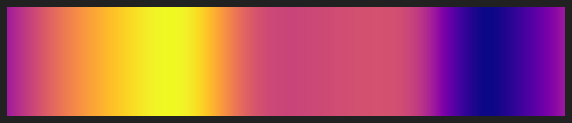

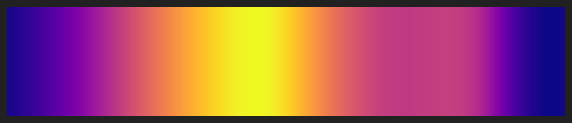

In [28]:
for i in range(y_trues[0].shape[0]):
    fig, ax = plt.subplots(figsize = (10,2))
    ax.imshow(y_trues[0][i,:].reshape(1,1024), cmap="plasma", aspect="auto")
    ax.set_yticks([])
    ax.set_xticks([])
    [ax.spines[key].set_visible(False) for key in ax.spines]
    ax.tick_params(axis='both')
    fig.patch.set_facecolor("#212121ff")


<ipython-input-14-207fea3e1077>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(yt, color = color, fontsize = 15)
<ipython-input-14-207fea3e1077>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xt, color = color, fontsize = 15)


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:xlabel='Longitud', ylabel='Valor numérico'>],
       dtype=object))

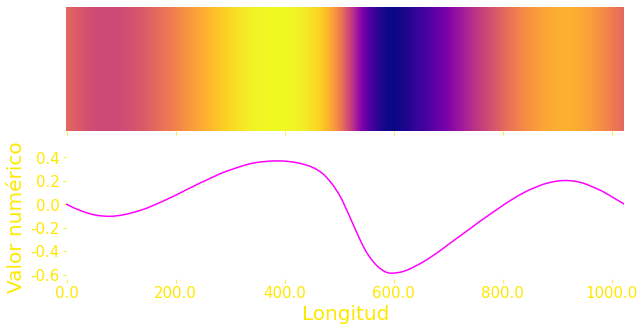

In [15]:
plot_burger(np.array(preds[0].cpu()[0,:]), name = "burger_pred", trsprnt = False)

In [19]:
y_trues

7

<ipython-input-14-207fea3e1077>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(yt, color = color, fontsize = 15)
<ipython-input-14-207fea3e1077>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xt, color = color, fontsize = 15)


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:xlabel='Longitud', ylabel='Valor numérico'>],
       dtype=object))

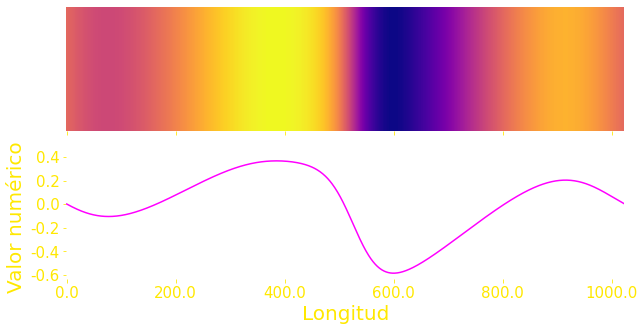

In [16]:
plot_burger(np.array(y_trues[0][0,:]), name = "burger_true")

<ipython-input-14-207fea3e1077>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(yt, color = color, fontsize = 15)
<ipython-input-14-207fea3e1077>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xt, color = color, fontsize = 15)


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:xlabel='Longitud', ylabel='Valor numérico'>],
       dtype=object))

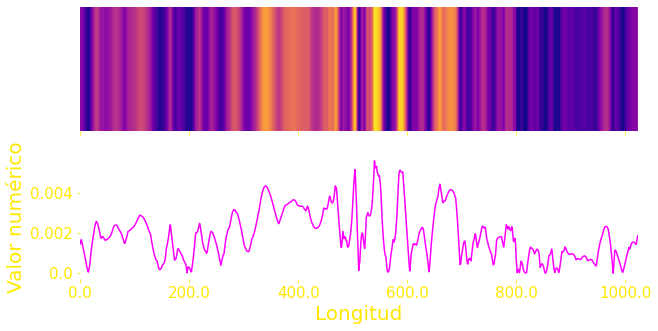

In [17]:
plot_burger(np.abs(np.array(preds[0].cpu()[0,:]) - np.array(y_trues[0][0,:])), name = "burger_error")